#Продвинутый Python, лекция 2

**Лектор:** Петров Тимур

**Семинаристы:** Петров Тимур, Коган Александра, Романченко Полина

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)

Итак, поговорили про основы, которые нам нужны не из Python, теперь пора начинать погружения в сам Python!

И сегодня мы начнем с некоторого must-have для аналитики/machine laearning и еще много чего:

* numpy

* pandas

* scipy

* datetime/dateutil (на семинаре сразу в практике)

* jax (на семинаре сразу с практикой)

Поехали!

![](https://i.pinimg.com/originals/77/18/b2/7718b2f6c858e331b76d6d0b8b01309b.gif)

Импортируем все, что нам будет нужно:

In [149]:
!pip install python-dateutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as st
import scipy.sparse as sp
import matplotlib.pyplot as plt
import dateutil as dt
import datetime as datetime

## Numpy

### Что это такое?

Что такое Numpy? Это библиотека, которая позволяет достаточно быстро выполнять различные операции с массивами (многомерными и не очень): перемножение, сложение, преобразования, базовый анализ данных

Вся работа в массивами в Numpy гораздо проще и быстрее, чем с обычными списками в Python. Давайте проверим это на простом примере

Достаточно часто в линале вам надо было перемножать матрицы, при этом внутри Python нет встроенного перемножения матриц. Без прочих оптимизаций типа алгоритма Штрассена и так далее, давайте попробуем перемножить две матрицы в чистом Python и с помощью numpy и сравним время

In [8]:
a = [[i for i in range(50)] for j in range(50)] #возьмем матрицу a размера 50x50
b = [[i for i in range(100)] for j in range(50)] #возьмем матрицу b размера 50x100

In [3]:
## Pure Python
def matmul_python(a,b):
    return [[sum(ele_a*ele_b for ele_a, ele_b in zip(row_a, col_b)) 
             for col_b in list(zip(*b))] for row_a in a]

In [4]:
#Numpy (сделаем функцию, чтобы было честнее)
def matmul_numpy(a, b):
    return np.matrix(a) * np.matrix(b)

In [11]:
%%time

k_python = matmul_python(a, b)

CPU times: user 37 ms, sys: 782 µs, total: 37.8 ms
Wall time: 41.4 ms


In [12]:
%%time

k_numpy = matmul_numpy(a, b)

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.86 ms


In [18]:
np.alltrue(k_python == k_numpy) #проверяем, что таблицы совпадают

True

Удивительно, Numpy почти в 30 раз быстрее, чем Python! За счет чего это получается?

Причин несколько:

* В первую очередь за счет ограничения со стороны размера: если в Numpy при создании объекта он имеет фиксированный размер (и если его надо поменять, то создастся новый объект и старый будет удален), то в Python нет фиксированного размера (что усложняет работу)

* За счет фиксированного размера массивы в NumPy и хранятся в памяти по-другому:

Numpy хранит данные друг за другом:

![Numpy](https://miro.medium.com/max/1400/1*g1qXNq68rV4gVfY4B7TTBA.png)

В свою очередь внутри Python элементы хранятся рандомно (поэтому когда вы обращаетесь к элементу, то вы обращаетесь к ссылке, ссылка идет в нужное место в памяти и находит его). С точки зрения выполнения арифметических операций это сложнее

![Python](https://miro.medium.com/max/1400/1*GbfijZi4QKIGwtv4Lqj0QA.png)

* А такое хранение позволяет гораздо проще итерироваться по массиву (итерация идет с помощью strides, говорящаяя, по сути, сколько бит надо пройти до следующего значения в строке/столбце)

Рассмотрим ситуацию с транспонированием: это же в Python надо брать и прямо переворачивать! А вот в Numpy мы по сути не меняем хранение данных, мы просто делаем другие strides!

Попробуйте запустить:

```
b = np.matrix(b)
print(b.strides)
print(b.T.strides)
```

И вы увидите, что поменялись strides (что говорит о том, что данные остались на местах, мы просто изменили то, как по нима ходить)

* Код в Numpy - это прекомпилированный код, написанных на C (то есть мы проходим более быстрый путь от компиляции до выполнения)

В целом этого уже достаточно, чтобы использовать Numpy (а теперь представьте, если делать все преобразования с массивами в моделях ML делать с помощью чистого Python, было бы безумие)

![](https://i.playground.ru/p/KD9p3ms8GKiSpcpgBcxYww.jpeg)

In [19]:
b = np.matrix(b)
print(b.strides)
print(b.T.strides)

(800, 8)
(8, 800)


### Как пользоваться?

А теперь о том, как пользоваться и что надо знать (будем учить матчасть)

Самое полезное - [документация](https://numpy.org/doc/stable/reference/index.html) (к ней в любом случае надо будет обращаться, знать все невозможно)

#### Создание



Массивы в Numpy называются ndarray (n-dimensional array). Массив можно создать из любого массива в Python, можно также создать из коробки

Обратите внимание: чтобы создать нормально ndarray из питоновских списков, нужно иметь в виду:

* Все элементы должны быть одного типа данных (иначе вы можете создадите массив, состоящий из питоновских листов, будет грустно, никакого эффекта), не полагайтесь на ум numpy

* Если у вас все ок, но при этом есть одни элемента float, другие int, то он может не привести самостоятельно все в формат float. Так что будет славно, если вы укажете тип элементов в ndarray

In [28]:
a = [1, 2, 2.7]

print(np.array(a))
print('-' * 30)
print(np.array(a, int)) #второй аргумент - тип. Если указать, то он попробует перевести все элементы в этот типа
print('-' * 30)
print(np.array(a, str)) # со строками тоже работает

a = [[1, 2, 'str'], [1, 2 ,3]]

print('-' * 30)
np.array(a) # он приведет, но хотели ли вы этого?..

[1.  2.  2.7]
------------------------------
[1 2 2]
------------------------------
['1' '2' '2.7']
------------------------------


array([['1', '2', 'str'],
       ['1', '2', '3']], dtype='<U21')

Из коробки можно создать много разных массивов, например:

* np.zeros - создать массив из нулей (аргументы - tuple размеров, опционально - тип)

In [31]:
np.zeros((3, 4), dtype=int) 

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

* np.ones - создать массив из единиц (аргументы - tuple размеров, опционально - тип)

In [32]:
np.ones((3, 4), dtype=float) 

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

* np.eye - создать массив из нулей и единиц на главной диагонали (аргументы - размеры матрицы, опционально - тип)

* np.identity(n) - создать единичную матрицу размера $n \times n$

In [38]:
np.eye(4, 3, dtype=str) 

array([['1', '', ''],
       ['', '1', ''],
       ['', '', '1'],
       ['', '', '']], dtype='<U1')

* np.empty - создать массив из рандомных элементов

In [37]:
np.empty((2, 3), float)

array([[4.277682e-316, 0.000000e+000, 0.000000e+000],
       [0.000000e+000, 0.000000e+000, 0.000000e+000]])

Функции для созданий одномерных массивов:

* np.arange(a, b, step) - аналог range (получаем массив)

* np.linspace(a, b, num, enndpoint=True) - получить равномерно $num$ значений от $a$ (включительно) до $b$ (до endpoint - включительно или нет) 

* np.logspace(a, b, num, endpoint=True, base=10.0) - получить равномерные значения по логарифмической шкале (от $base^a$ до $base^b$) 

In [41]:
print(np.arange(0, 10))
print(np.linspace(0, 10, 11, endpoint=True))
print(np.logspace(2, 4, 5, endpoint=True, base=2))

[0 1 2 3 4 5 6 7 8 9]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 4.          5.65685425  8.         11.3137085  16.        ]


Теперь про другие способы создать ndarray. Очевидно, что вам часто потребуется загрузить из каких-то других источников (например, вам дали файл и сказали: делай)

Варианты:

* np.loadtxt(file, delimeter, skiprows=0) - возьми данные из текста, разделяются через delimeter (например, \t - табами), скипни skiprows строк (если там вам не нужны названия, например)

* np.fromstring(s, sep) - загрузи из строки

* np.load(file) - загрузи из файла (работает для всяких штук типа .npy, .npz)

#### Индексация

Тут все достаточно просто - обращение как в питоновских списках

In [18]:
a = np.arange(28)
a = a.reshape(2, -1)
print(a[0][0], a[0, 0]) # обращение к элементу, несколько вариантов
print(a[:1]) # вывести строку
print(a[-1][5:7]) # вывести последнюю строку и часть столбцов
print(a[:, 5:7]) # вывести столбцы

0 0
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]]
[19 20]
[[ 5  6]
 [19 20]]


#### Арифметика

Ну почти как везде (операции с числами считаются как операции со скаляром):

* +, - - сложение-вычитание (поэлементно)

* \* - умножение (поэлементное)

* .T - транспонирование

* A.dot(B) - перемножение матриц

In [48]:
np.random.seed = 1514 ##зададим какой-нибудь seed

a = np.empty((3, 3))
b = np.empty((3, 3))

print(a)
print(b)
print(a + b)
print(a - b)
print(a * b)
print(a.dot(b))

[[ 1.11111111  2.22222222  3.33333333]
 [ 4.44444444  5.55555556  6.66666667]
 [ 7.77777778  8.88888889 10.        ]]
[[ 1.11111111  2.22222222  3.33333333]
 [ 4.44444444  5.55555556  6.66666667]
 [ 7.77777778  8.88888889 10.        ]]
[[ 2.22222222  4.44444444  6.66666667]
 [ 8.88888889 11.11111111 13.33333333]
 [15.55555556 17.77777778 20.        ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[  1.2345679    4.9382716   11.11111111]
 [ 19.75308642  30.86419753  44.44444444]
 [ 60.49382716  79.01234568 100.        ]]
[[ 37.03703704  44.44444444  51.85185185]
 [ 81.48148148 100.         118.51851852]
 [125.92592593 155.55555556 185.18518519]]


Умножений, на самом деле, есть несколько:

* a * b - поэлементный (обратите внимание, если a и b типа matrix, то это просто умножение)

* a.dot(b) и np.dot(a, b) - умножение матриц (a на b)

* np.matmul(a, b) и a @ b - умножение матриц, но тут сложнее :)

In [65]:
a = np.arange(2 * 2 * 4 * 5).reshape((2, 5, 2, 4))
b = np.arange(2 * 2 * 4 * 5).reshape((2, 5, 4, 2))
np.matmul(a,b).shape

(2, 5, 2, 2)

#### Размерности

Что-то можем сделать, кайф. Теперь давайте поговорим про размерности, потому что с этим вы будете сталкиваться чаще всего и вообще не выкупать, а почему у меня ничего не перемножается, какие размерности надо etc (но чаще это будет в pandas)

Базово:

* shape - посмотреть размерности

* reshape - привести к новым размерностям (работает как transpose - меняем strides)

* ravel/flatten - приведи к одномерному массиву

* newaxis - добавь размерность

А теперь в деталях:

In [69]:
a = np.arange(28)
print(a.shape) # размерность 28, логично
print(a.reshape(2, -1).shape) #приведи к размеру 2 x 14 (-1 значит все остальное)
# если новая размерность не влезает (то есть у вас 28 элементов, а вы хотите размер (3, 2, 5)), то выдаст ошибку
print(a.reshape(3, 2, 5))

(28,)
(2, 14)


ValueError: ignored

In [75]:
a = a.reshape(2, -1) # сама по себе не меняет размерность
print(a.flatten())
print(a.ravel())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


Получаем одно и то же, но функции разные, в чем прикол?

* flatten возвращает копию (то есть она независима от исходного массива)

* ravel создает только view (то есть ссылку на origin), и если поменять в исходном массиве значение, то и в ravel оно измениться (имейте это ввиду)

In [77]:
a_f = a.flatten()
a_r = a.ravel()
a[0][0] = 1
print(a_r) # изменилось, ух ты!

[ 1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


А теперь допустим, что нам нужно не уменьшить число размерностей, а наоборот, их добавить

Это можно сделать с помощью newaxis!

In [11]:
a = np.arange(28)
a = a.reshape(2, -1)
print(a.shape)
a_new = a[:, np.newaxis, :] #указываем newaxis туда, куда нам нужно, : значит возьми все
print(a_new.shape)
a = a.reshape(2, 1, -1) #можно и сделать с помощью reshape
print(a.shape)

(2, 14)
(2, 1, 14)
(2, 1, 14)


#### Соединения и добавления

Представим новую ситуацию: у вас есть два набора данных (допустим, за прошлую неделю и за текущую) и вы хотите их соединить их в единый набор данных

Или же у вас одна половина данных лежит в одной, а другая в другой (скажем, есть карточка товара, в одном месте лежит вся информация про id, название etc, а в другом всякие web-счетчики: сколько посмотрели-покликали и так далее)

Тогда на помощь приходят:

* np.concatenate((arr1, arr2), axis) - соедини две таблицы по выбранному axis (по дефолту 0)

* np.vstack((arr1, arr2)) - соедини две таблицы строчно (то есть друг под другом).То же самое, что и np.concatenate((arr1, arr2), axis=0)

* np.hstack((arr1, arr2)) - соедини две таблицы по колонке (то есть arr1-arr2).То же самое, что и np.concatenate((arr1, arr2), axis=1)

**Как и в перемножении матриц, размерности должны сходиться!**

In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

print(np.vstack((a, b)))
print(np.hstack((a, b)))
print(np.concatenate((a, b), axis=0))
print(np.concatenate((a, b), axis=1))

А если хотим добавить?

* np.append(arr_1, arr_2, ..., arr_n, axis) - сделай append (если отдельно задаете axis, то размерности должны быть одинаковыми)

* np.insert(arr, slice, value, axis) - добавь в arr в slice значение value по выбранному axis

* np.resize(arr, (sizes)) - по сути reshape, но если получившийся итог получается больше, то заполняет остальное копией a (аккуратнее с этим, лучше не делать с матрицами)

* arr.resize((sizes)) - reshape, если больше, то заполнит нулями (аккуратно с этим)

In [35]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

print(np.append(a, b)) 
print('-' * 30)
print(np.insert(a, 1, b, axis = 0))
print('-' * 30)
print(np.resize(a, (5, 2)))
print('-' * 30)
a.resize((1, 10), refcheck=False) ## refcheck - не проверяй на наличие ссылок (иначе упадет)
print(a)
print('-' * 30)
a = np.array([[1, 2], [3, 4]])
print(np.append(a, [1, 2])) 

[1 2 3 4 5 6 7 8]
------------------------------
[[1 2]
 [5 6]
 [7 8]
 [3 4]]
------------------------------
[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]]
------------------------------
[[1 2 3 4 0 0 0 0 0 0]]
------------------------------
[1 2 3 4 1 2]


#### Сравнения

Все, помучили наш массив как только можем, давайте теперь его как-то исследовать

Допустим, теперь хотим что-то отфильтровать или посмотреть какие-то конкретные значения

In [46]:
a = np.arange(30)
print(a[(a > 15) & (a < 27) | (a < 9)]) # как добавить несколько условий сразу через & и | (и/или)
cond = (a > 15) & (a < 27) | (a < 9) # условия можно отдельно записывать, даст массив True-False
print('-' * 30)
print(a[cond])
print(cond)

[ 0  1  2  3  4  5  6  7  8 16 17 18 19 20 21 22 23 24 25 26]
------------------------------
[ 0  1  2  3  4  5  6  7  8 16 17 18 19 20 21 22 23 24 25 26]
[ True  True  True  True  True  True  True  True  True False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True False False False]


In [53]:
a = np.arange(30).reshape(5, -1)
b = (np.arange(30) - 1).reshape(5, -1)
b[0][0] = 15
a > b #для таких сравнений должны быть одинаковые размерности

array([[False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [63]:
print((a > b).all()) # проверить, все ли значения True
print((a > b).any()) # првоерить, есть ли хотя бы одно True
print(a[a > b]) # выведет одномерный массив
print('-' * 30)
print(a[a[:, 0] > [1, 1, 1, 1, 1]]) # можно сравнивать и вот так

False
True
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
------------------------------
[[ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]]


Теперь хотим применить условие и что-то сделать со значениями (обрезать или поменять)

Можно по старинке:

In [66]:
a = np.arange(30).reshape(5, -1)
a[a > 0] = a[a > 0] * 5
a

array([[  0,   5,  10,  15,  20,  25],
       [ 30,  35,  40,  45,  50,  55],
       [ 60,  65,  70,  75,  80,  85],
       [ 90,  95, 100, 105, 110, 115],
       [120, 125, 130, 135, 140, 145]])

Но можно и лучше!

* np.where(cond, act_1, act_2) - измени значения в зависимости от условия (если True, то сделай одно, если False, то другое)

* np.clip(arr, a_min, a_max) - ограничить значения (все, что меньше a_min, станет a_min, все, что больше a_max, станет a_max)

Последнее нужно, например, для обработки картинок (допустим, вам пришли плохие данные, где есть значения не в пределах от 0 до 256)

In [73]:
a = np.arange(30).reshape(5, -1)
a = np.where(a > 0, a * 5, a)
print(a)
print('-' * 30)
a = np.clip(a, 10, 100)
print(a)

[[  0   5  10  15  20  25]
 [ 30  35  40  45  50  55]
 [ 60  65  70  75  80  85]
 [ 90  95 100 105 110 115]
 [120 125 130 135 140 145]]
------------------------------
[[ 10  10  10  15  20  25]
 [ 30  35  40  45  50  55]
 [ 60  65  70  75  80  85]
 [ 90  95 100 100 100 100]
 [100 100 100 100 100 100]]


#### Прочие полезные вещи

Все, теперь к полному анализу наших данных!

![](https://i.gifer.com/embedded/download/3nHQ.gif)

Что умеем?

*   sum, mean, std, min, max, prod - классика (сумма, среднее, стандратное отклонение, минимум/максимум, произведение)

*   argmin, argmax - найди индекс максимума/минимума (знаете же, что в Python так нельзя, а вот тут пожалуйста)

* nonzero - вывести индексы ненулевых значений

* sort, unique - сортировка, уникальные элементы

* diag, trace - вывести диагональ, след матрицы (работает только для размерности < 3)

* cumsum, cumprod - кумулятивы сумм-произведений

* isnan, isinf, isposinf, isneginf - поиск "плохих" значений

* nan_to_num(x, nan, posinf) - если где-то видим nan или inf, то можем его поменять на значение в nan или posinf



In [81]:
a = np.array([[[1, 2, 3], [4, 5 ,6], [7, 8, 9]], [[-np.inf, 2, 3], [4, np.nan ,6], [np.nan, 8, np.inf]]])
print(np.argwhere(np.isnan(a)))
print('-' * 30)
print(np.argwhere(np.isinf(a)))
print('-' * 30)
print(np.argwhere(np.isposinf(a)))
print('-' * 30)
print(np.argwhere(np.isneginf(a)))
print('-' * 30)

[[1 1 1]
 [1 2 0]]
------------------------------
[[1 0 0]
 [1 2 2]]
------------------------------
[[1 2 2]]
------------------------------
[[1 0 0]]
------------------------------


In [90]:
np.nan_to_num(a, copy=False, nan=0, posinf=999, neginf=-999)
#очень часто у функций есть аргумент copy, то есть создавать новую копию или менять в исходном массиве
print(a.sum()) # полная сумма
print('-' * 30)
print(a.sum(axis=0)) # сумма по оси
print('-' * 30)
print(a.std())

68.0
------------------------------
[[-998.    4.    6.]
 [   8.    5.   12.]
 [   7.   16. 1008.]]
------------------------------
333.01310544040416


In [94]:
print(np.cumsum(a))
print('-' * 30)
print(np.cumprod(a)) # 

[   1.    3.    6.   10.   15.   21.   28.   36.   45. -954. -952. -949.
 -945. -945. -939. -939. -931.   68.]
------------------------------
[ 1.00000000e+00  2.00000000e+00  6.00000000e+00  2.40000000e+01
  1.20000000e+02  7.20000000e+02  5.04000000e+03  4.03200000e+04
  3.62880000e+05 -3.62517120e+08 -7.25034240e+08 -2.17510272e+09
 -8.70041088e+09 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


#### Линейная алгебра (np.linalg)

Самый сильный инструмент внутри numpy - это модуль numpy.linalg, который позволяет применить кучу методов из линейной алгебры (например, сделать за вас тот же самый SVD)

Из основного:

* numpy.linalg.multi_dot - перемножение нескольких матриц сразу (причем выбирается самый быстрый способ перемножения)

* np.vdot - скалярное произведение (не нужно делать .T  
как минимум)

* numpy.linalg.matrix_power - возвести матрицу в нужную степень

* numpy.linalg.norm - матричная норма

* numpy.linalg.det - определитель матрицы 

* numpy.linalg.inv - обратная матрица (если нет, то будет считать через pinv - псевдообратная матрица)

* numpy.linalg.solve(a, b) - решить систему $ax = b$

Разложения:

* choletsky, qr, SVD - разложение Холецкого, QR-декомпозиция, SVD-разложение (можно сделать усеченным)

* eig, eigvals - собственные вектор**Ы** и собственные значения 


In [107]:
A = np.matrix([[1, 2, 3], [4, 5, 11], [7, 8, 10]])
print("Определитель матрицы:", lin.det(A))
print('-' * 30)
print("Обратная матрица:", lin.inv(A))
print('-' * 30)
print("Третья степень матрицы:", lin.matrix_power(A, 3))
print('-' * 30)
b = np.array([1, 2, 3])
print("Решаем систему:", lin.solve(A, b))
print('-' * 30)
c = np.array([1, 2, 3])
print("Скалярное произведение:", np.vdot(c, b))
print('-' * 30)

Определитель матрицы: 27.0
------------------------------
Обратная матрица: [[-1.40740741  0.14814815  0.25925926]
 [ 1.37037037 -0.40740741  0.03703704]
 [-0.11111111  0.22222222 -0.11111111]]
------------------------------
Третья степень матрицы: [[ 559  680 1036]
 [1824 2223 3404]
 [2108 2560 3891]]
------------------------------
Решаем систему: [-0.33333333  0.66666667  0.        ]
------------------------------
Скалярное произведение: 14
------------------------------


In [109]:
U, s, Vh = lin.svd(A)
print(U)
print('-' * 30)
print(s)
print('-' * 30)
print(Vh)

[[-0.18951531 -0.10237519 -0.97652612]
 [-0.6434869  -0.73824699  0.20227702]
 [-0.74162562  0.66671636  0.07403202]]
------------------------------
[19.51894064  2.78648927  0.496421  ]
------------------------------
[[-0.40754477 -0.48821656 -0.77172006]
 [ 0.5783806   0.51597023 -0.63186281]
 [ 0.70667046 -0.70386029  0.07209402]]


In [111]:
lin.eig(A)

(array([18.83666805, -0.65787568, -2.17879237]),
 matrix([[-0.19655135, -0.61840136,  0.01695951],
         [-0.64434967,  0.7673012 , -0.84013156],
         [-0.73904064, -0.16978994,  0.54211746]]))

#### Выгрузка

Ну все, потрудились, можно и результаты сохранить:

* np.save(name, arr) -  сохранить файл с раширением .npy

* np.savetxt(file, arr) - сохранить файл в txt

## Pandas

![Excel](https://i.kym-cdn.com/photos/images/newsfeed/001/707/025/945.jpg)

Все видели эту картинку (ну в общем-то это правда). Однако можно же не только Экселем пользоваться

Вот для этого и есть Pandas. Помимо того, что это такие таблицы, чтобы заменить Эксель, это еще и очень удобная штука для EDA (exploratory data analysis)

[Документация](https://pandas.pydata.org/docs/)

### Начинаем

Будем смотреть это все на данных про аниме и их рейтингов

![аниме](https://steamuserimages-a.akamaihd.net/ugc/795365202390752570/FF835BAC56853D50EEAE303BFEF92369987ADEDE/?imw=512&amp;imh=400&amp;ima=fit&amp;impolicy=Letterbox&amp;imcolor=%23000000&amp;letterbox=true)

In [ ]:
!wget https://github.com/Palladain/Deep_Python/blob/main/Lectures/Lecture_2/archive.zip

In [ ]:
!unzip archive.zip

Загрузить pandas DataFrame из файла можно с помощью:

* read_csv(file, delimeter, sep) - прочитай файл из csv с разделителями delimeter и sep (по дефолту это запятая, потому что csv)

* read_table(file, delimeter, sep) - прочитай из файла

In [199]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

Посмотрим, что там находится. Это можно сделать с помощью функций:

* pd.head(n) - посмотреть первые n строк

* pd.tail(n) - посмотреть последние n строк

* ну или просто вызвать сам dataframe

In [193]:
anime.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [194]:
rating.tail(10)

,user_id,anime_id,rating
7813727,73515,13161,8
7813728,73515,13331,9
7813729,73515,13599,7
7813730,73515,13659,8
7813731,73515,14345,7
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9
7813736,73516,8074,9


Можно создать и из коробки:

In [196]:
df = pd.DataFrame([[1,'A', 'Ahah'],
                  [2,'B', 'Ahah'],
                  [3,'C', 'Ahaha']], 
columns=['id','name', 'surname'])
df

,id,name,surname
0,1,A,Ahah
1,2,B,Ahah
2,3,C,Ahaha


Одна из важных составляющих - это копирование. Почему?

Потому что очень часто вы будете видеть предупреждение, что пытаетесь изменить или сделать слайс в оригинальном датасете или в копии (и вас это будет мучать). Так что тут важно каждый раз понимать - копия или не копия

Чтобы явно скопировать, мы делаем copy

In [197]:
anime_2 = anime.copy(deep=True) #deep говорит, что физически его надо скопировать

### Первые шаги

In [202]:
print(len(anime)) #сколько строк в массиве
print('-' * 30)
print(anime.info()) #описание для всех
print('-' * 30)
print(anime.describe()) # общее описание для нестроковых данных

12294
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
------------------------------
           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000 

Первое, что нас напрягает - число эпизодов же тоже число, почему он object? Давайте посмотрим на все уникальные значения:

In [203]:
anime.episodes.unique() #вывести все уникальные значения
#Любой столбец в DataFrame - это Series. Здесь у нас array, поскольку unique() преобразовывает
#Видим Unknown, печаль

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [211]:
# Отфильтруем и посмотрим, где там Unknown
anime[anime.episodes == 'Unknown'][['name', 'genre', 'episodes']] #выберем еще конкретные колонки
# Ну это аниме, что еще не все до конца вышло (да, это старая таблица, в Наруто тут еще не кончились серии)

,name,genre,episodes
74,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Unknown
252,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",Unknown
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",Unknown
991,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",Unknown
1021,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Unknown
...,...,...,...
12265,Kyonyuu Reijou MC Gakuen,Hentai,Unknown
12274,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,Unknown
12280,Saimin Class,Hentai,Unknown
12282,Shikkoku no Shaga The Animation,Hentai,Unknown


Как исследовать колонки со строками? Можно с помощью value_counts():

In [214]:
anime.genre.value_counts() #тут тоже получаем Series

Hentai                                                  823
Comedy                                                  523
Music                                                   301
Kids                                                    199
Comedy, Slice of Life                                   179
                                                       ... 
Adventure, Drama, Fantasy, Game, Sci-Fi                   1
Adventure, Demons, Fantasy, Historical                    1
Action, Comedy, Drama, Mecha, Music, Sci-Fi, Shounen      1
Action, Comedy, Fantasy, Mecha, Sci-Fi, Shounen           1
Hentai, Slice of Life                                     1
Name: genre, Length: 3264, dtype: int64

Хотим добавить новую колонку (например, флаг, что это все аниме):

In [215]:
anime['is_anime'] = True
anime.head(10)

,anime_id,name,genre,type,episodes,rating,members,is_anime
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,True
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,True
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,True
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,True
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,True
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,True
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,True
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,True
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,True


А допустим хотим удалить, это делается вот так (удалим из копии):

In [218]:
anime_2.drop(['rating', 'members'], axis=1).head()

,anime_id,name,genre,type,episodes
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51


Отдельно для столбцов можно смотреть суммы, среднее, минимум/максимум, медиану, а также стандартное отклонение:

In [223]:
print(anime.rating.sum())
print('-' * 30)
print(anime.rating.mean())
print('-' * 30)
print(anime.rating.std())
print('-' * 30)
print(anime.rating.min())
print('-' * 30)
print(anime.rating.max())
print('-' * 30)
print(anime.rating.median())

78101.15
------------------------------
6.473901690981432
------------------------------
1.0267463068980571
------------------------------
1.67
------------------------------
10.0
------------------------------
6.57


### Слияние строк и поиск по строкам

Хотим искать нужные нам строки (либо по индексам, либо по значениям):

In [233]:
anime[1:3][['anime_id', 'name', 'genre']] #вывести строчки

,anime_id,name,genre
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."


Давайте поменяем индекс и сделаем anime_id в качестве основного индекса:

In [242]:
anime = anime.set_index('anime_id') #сделать колонку индексом
anime = anime.reset_index() #вывести колонку из индекса и поставить индекс по номеру строки
anime = anime.set_index('anime_id') #сделать колонку индексом

In [243]:
anime.loc[[1, 15]] #выбираем строки по индексу

,name,genre,type,episodes,rating,members,is_anime
anime_id,,,,,,,
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True
15,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145,8.08,83648,True


In [244]:
anime.iloc[[1, 16]] #выбираем строчки по номеру (если индекс отличается)

,name,genre,type,episodes,rating,members,is_anime
anime_id,,,,,,,
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True
23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,22,8.92,416397,True


Допустим, мы хотим добавить новое аниме (допустим, [Атаку титанов](https://en.wikipedia.org/wiki/Attack_on_Titan_(TV_series))):

In [249]:
print(list(anime.columns)) #посмотрели колонки

new_anime = pd.DataFrame([['Attack on Titans', 'Action, Dark fantasy', 'TV', '87', 9.0, 100000, True]]
                         , columns = list(anime.columns))
new_anime

['name', 'genre', 'type', 'episodes', 'rating', 'members', 'is_anime']


,name,genre,type,episodes,rating,members,is_anime
0,Attack on Titans,"Action, Dark fantasy",TV,87,9.0,100000,True


In [250]:
anime = pd.concat([anime, new_anime]) #есть еще ignore_index, если его проставить, то тогда индекс поменяется на от 0 до конца
anime #ура, доабвили

,name,genre,type,episodes,rating,members,is_anime
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,True
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,True
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,True
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,True
...,...,...,...,...,...,...,...
5543,Under World,Hentai,OVA,1,4.28,183,True
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,True
6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,True
26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,True


Ладно, удалим для простоты:

In [253]:
anime = anime.drop([0])
anime

,name,genre,type,episodes,rating,members,is_anime
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,True
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,True
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,True
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,True
...,...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,True
5543,Under World,Hentai,OVA,1,4.28,183,True
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,True
6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,True


### Сортировка и агрегация

Хотим посмотреть самые худшие аниме по версии людей:

In [252]:
anime.sort_values('rating', ascending=True).head(10) # что такое жанр Dementia...

,name,genre,type,episodes,rating,members,is_anime
34476,Platonic Chain: Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life",Special,1,1.67,51,True
20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129,True
3287,Tenkuu Danzai Skelter+Heaven,"Mecha, Sci-Fi",OVA,1,2.00,7680,True
13405,Utsu Musume Sayuri,"Comedy, Dementia",OVA,1,2.14,4047,True
413,Hametsu no Mars,"Horror, Sci-Fi",OVA,1,2.37,27557,True
14781,Roboteuwang Sseonsyakeu,"Action, Mecha, Sci-Fi",Movie,1,2.49,121,True
24259,Mechano: Scientific Attack Force,"Comedy, Dementia, Fantasy, Horror, Music, Parody",OVA,3,2.55,120,True
33863,Cakes,Comedy,ONA,Unknown,2.58,56,True
31634,Kokuhaku,Horror,ONA,1,2.67,816,True
29949,Nami,Dementia,Movie,1,2.67,1817,True


Хотим теперь агрегировать какие-нибудь значения (например, хочу узнать по типу средний рейтинг, а еще их число). Это можно сделать с помощью groupby (тут уже синтаксис становится все более похожим на SQL):

In [257]:
anime.groupby(["type"]).agg({"rating": "mean", "name": "count"}).reset_index() #красота, можно использовать

,type,rating,name
0,Movie,6.318058,2348
1,Music,5.588996,488
2,ONA,5.643298,659
3,OVA,6.375221,3311
4,Special,6.523501,1676
5,TV,6.902299,3787


### JOIN THE NAVY

Не забудем, что у нас еще есть таблица rating. Давайте на нее посмотрим отдельно:

In [259]:
rating.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Видим anime_id, как и в исходной таблице. Теперь бы нам join сделать было бы хорошо. Давайте так и сделаем:

In [266]:
anime.join(rating.set_index('anime_id'), lsuffix='_anime', rsuffix='_user')
#чтобы смапить нужен общий индекс, если есть одинаковые колонки (rating), то добавляем суффиксы, дабы не было коллизий

,name,genre,type,episodes,rating_anime,members,is_anime,user_id,rating_user
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True,13.0,-1.0
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True,19.0,10.0
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True,21.0,9.0
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True,23.0,9.0
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,True,32.0,10.0
...,...,...,...,...,...,...,...,...,...
34514,Pokemon Generations,"Action, Adventure, Fantasy, Game, Kids",ONA,18,7.21,295,True,NaN,NaN
34519,Mobile Suit Gakuen: G-Reco Koushien,Comedy,Special,9,5.67,94,True,48766.0,-1.0
34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,Unknown,NaN,381,True,NaN,NaN
34525,Centaur no Nayami,"Comedy, Fantasy, Slice of Life, Supernatural",TV,Unknown,NaN,108,True,NaN,NaN


### Apply

Есть очень крутая фича, называется apply. Допустим, что мы хотим создать колонку, где будет отмечать контент 18+ (то есть по жанру Хентай). С помощью apply, смотря на значение и применив лямбда-функцию, мы получим то, что нужно:

In [269]:
anime

,name,genre,type,episodes,rating,members,is_anime
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,True
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,True
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,True
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,True
...,...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,True
5543,Under World,Hentai,OVA,1,4.28,183,True
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,True
6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,True


In [270]:
anime.genre.unique()

array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       ..., 'Hentai, Sports', 'Drama, Romance, School, Yuri',
       'Hentai, Slice of Life'], dtype=object)

In [273]:
anime["adult"] = anime.genre.apply(lambda x: int('Hentai' in str(x))) # то есть берем значения в genre, для них берем лямбда функцию и итерируемся
anime

,name,genre,type,episodes,rating,members,is_anime,adult
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,True,0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,True,0
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,True,0
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,True,0
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,True,0
...,...,...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211,True,1
5543,Under World,Hentai,OVA,1,4.28,183,True,1
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219,True,1
6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,True,1


### Запись

Поработали и хватит. Давайте запишем наши данные, чтобы они были и нам не пришлось все запускать заново:

In [274]:
anime.to_csv("anime_new.csv") #запиываем в csv

## Scipy

Scipy - это несколько специфичная библиотека для различных более математическиз вещей типа преобразований Фурье, интерполяций, оптимизаций etc. Вот там можно реально закопаться ([документация](https://docs.scipy.org/doc/scipy/reference/index.html#) в помощь)

Но сегодня мы рассмотрим всего 2 библиотеки, которые вам могут встретиться чаще, чем обычно:

* stats - распределения, статистики, корреляции, тесты и так далее

* sparse - модуль для разреженных данных

### Stats

В курсе по теории вероятности вы познакомитесь с огромным количеством разных распределений (Бернулли, Пуассона, нормальное, Коши, равномерное etc)

Было бы круто, если бы была библиотека, которая может сэмлировать из таких распределений... 🤔🤔🤔

А, подождите, для этого есть scipy.stats

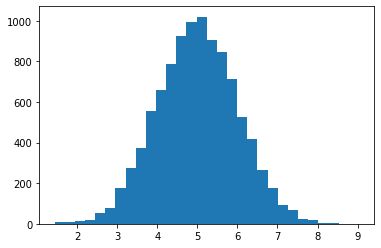

In [138]:
n = st.norm(5, 1) # возьмем нормальное распределение со средним 5 и gamma = 1
plt.hist(n.rvs(10000), bins=30) #.rvs - сгенерировать сэмпл
plt.show() #ну, очень похоже на нормальное распределение

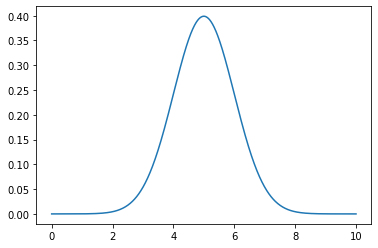

In [139]:
x = np.linspace(0, 10, 1000)
plt.plot(x, n.pdf(x))
plt.show()

Основное:

* .rvs(size) - сгенерировать выборку нужного размера

* .pdf(val) - значение плотности вероятности в данной точке

* .ppf(perc) - квантили

* .mean, .std, .var - среднее, стандратное отклонение, дисперсия


In [148]:
n = st.bernoulli(0.3) #распределение Бернулли с p = 0.3 (p - вероятность выпадения 1)
n.rvs(1000).sum() #почти 30% выпадения 1

309

На самом деле, сейчас это может быть не так важно и нужно, но как только вы перейдете к матстату и полному терверу, то сразу понятно станет, как же это удобно (мы с вами потренируемся с этим на семинаре на примере одного датасета)

### Sparse

Так или иначе, у вас может получиться разреженная матрица (то есть это матрица, где очень много нулей и лишь малое число ненулей). Хранить такую матрицу как она есть - это очень грустно с точки зрения памяти (мы храним кучу безполезной информации)

Для этого и придумали sparse модуль. В чем особенность? Давайте хранить вместо самой матрицы ее размеры и места, где находятся ненулевые значения, а потом при взаимодействии это обрабатывать отдельно

Модуль sparse очень хорошо работает с Numpy, так что в этом смысле никаких проблем нет, самое главное - если где-то получается что-то типа sparse матрицы, то в этом поможет именно Scipy

In [121]:
A = sp.lil_matrix((1000, 1000)) #создаем матрицу
A[0, :100] = np.random.rand(100) # заполним рандомными значениями
A[1, 100:200] = A[0, :100]
A.setdiag(np.random.rand(1000)) #заполним диагонали, чтобы система была решаемой

In [ ]:
A = A.tocsr() # переводим в формат sparse матрицы A.to_array() - вернуть обратно в формат обычной матрицы
b = np.random.rand(1000)
x = sp.linalg.spsolve(A, b) #решаем уравенение
x # получаем такое же решение, как и в случае обычных матриц, но храним меньше данных

## Итоги

На семинаре мы возьмем этот багаж, обогатим работой со временем и вперед, будем крутить-вертить датасет)

![](https://mnogo-krolikov.ru/wp-content/uploads/2019/10/https-avatars-mds-yandex-net-get-pdb-877347-9092.jpeg)

А это какапо, самый большой попугай на Земле. А еще он нелетающий (крылья у него есть, он с их помощью плюхается с деревьев иногда, но нет, он не умеет летать). Они очень забавные, приятно пахнут, и очень привыкают к людям :з 

Они ведут ночной образ жизни и по сути заменяли млекопитающих на островах Новой Зеландии, но из-за всяких кошек, горностаев и прочих животных, привезенных извне, был почти истреблен. Сейчас их всего 200 особей, которые обитают на специально изолированных островах

Но хорошая новость в том, что за последние года их стало больше и они вполне неплохо себе живут :)